In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import text
from sklearn.metrics import classification_report

# from tqdm.notebook import tqdm    
# from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from sklearn.feature_extraction.text import CountVectorizer
# from yellowbrick.style import set_palette
# from yellowbrick.text import FreqDistVisualizer

In [2]:
# connecting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# impoorting datasets
train = pd.read_csv('/content/drive/MyDrive/DM LAB/train.csv')
validation = pd.read_csv('/content/drive/MyDrive/DM LAB/valid.csv')

In [4]:
train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


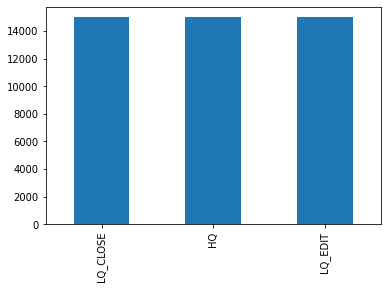

In [5]:
train.Y.value_counts().plot.bar()

In [6]:
import re

In [7]:
# removing HTML tags
regex = re.compile(r'<[^>]+>')
def remove_html(string):
    return regex.sub('', string)
train['Text']=train.Body.apply(remove_html)
validation['Text']=validation.Body.apply(remove_html)
train.head(5)

,Id,Title,Body,Tags,CreationDate,Y,Text
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,I'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,I'd like to understand why Java 8 Optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,I am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"The question is very simple, but I just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,I'm using custom floatingactionmenu. I need to...


In [8]:
# converting text to lowercase
train['Text']=train['Text'].str.lower()
validation['Text']=validation['Text'].str.lower()
train.head(5)

,Id,Title,Body,Tags,CreationDate,Y,Text
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,i'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,i'd like to understand why java 8 optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,i am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"the question is very simple, but i just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,i'm using custom floatingactionmenu. i need to...


In [9]:
# max features - top n words from vocab
# max len - max length of sentence
MAX_FEATURES = 20000
MAX_LEN = 200

In [10]:
from tqdm.notebook import tqdm # show timer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.style import set_palette
from yellowbrick.text import FreqDistVisualizer
# from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

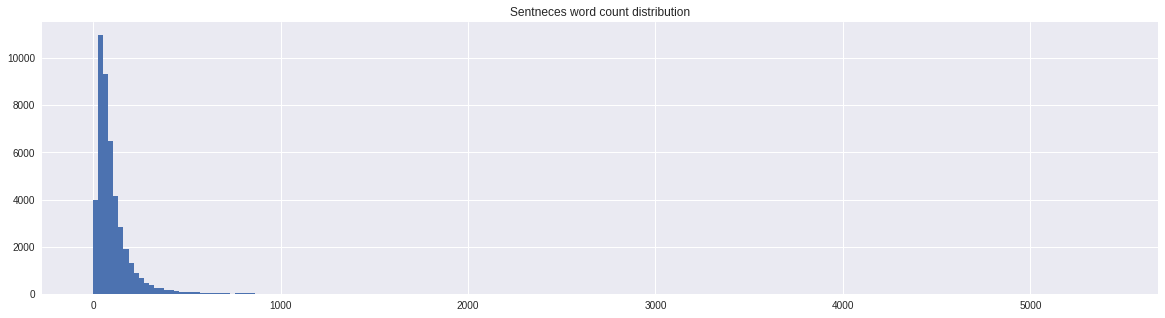


Max length: 5412 / Min length: 1 / Mean length: 106 / Max limit length: 200


In [11]:
X=train['Text'].values

plt.style.use('seaborn')

# init tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES)

# generating vocabulary index based on word frequency
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# takes each word in the text and replaces it with its
# corresponding integer value from the word_index dictionary.
sequences = tokenizer.texts_to_sequences(X)
# print(sequences)

result = [len(x.split()) for x in X]

plt.figure(figsize=(20,5))
plt.title('Sentneces word count distribution')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()

print()
print('Max length: %i / Min length: %i / Mean length: %i / Max limit length: %i' % (np.max(result), np.min(result), np.mean(result), MAX_LEN))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


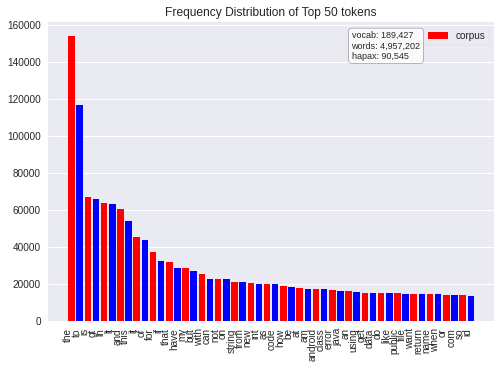

In [12]:
# vectorization of the tokens generated

# init vectorizer
vectorizer = CountVectorizer()
# transform a given text into a vector on the basis of the frequency
# of each word that occurs in the entire text
docs       = vectorizer.fit_transform(X)
features   = vectorizer.get_feature_names()

# frequency distribution graph for each item in the text
visualizer = FreqDistVisualizer(features=features, orient='v',color=["red", "blue"])
visualizer.fit(docs)
visualizer.show()

In [13]:
# text correlation with title
text_df = train[['Title','Y']].sample(frac=0.1)
codes, uniques = pd.factorize(text_df.Y)
text_df['Y'] = codes
text_df['Title'] = text_df.Title.str.replace('\(|\)|,|\.|\"','')
s_corr = text_df.Title.str.lower().str.get_dummies(sep=' ').corrwith(text_df.Y/text_df.Y.max())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [14]:
s_corr.sort_values(ascending=False)[:5]

help      0.114442
sql       0.097910
please    0.094842
am        0.084419
me        0.074392
dtype: float64

In [15]:
s_corr.sort_values(ascending=True)[:5]

best          -0.050662
does          -0.048388
information   -0.045652
giving        -0.045652
int           -0.045490
dtype: float64

In [16]:
EPOCHS = 15
BATCH_SIZE = 24
#MAX_LEN = 192

In [17]:
# encode target variable to binary categories

encoder = LabelEncoder()
encoder.fit(train.Y.values)
encoded_Y_train = encoder.transform(train.Y.values)
encoded_Y_valid = encoder.transform(validation.Y.values)


x_train = train.Text.values
x_valid = validation.Text.values

# matrix creation, present -> 1 , empty -> 0
y_train = np_utils.to_categorical(encoded_Y_train)
y_valid = np_utils.to_categorical(encoded_Y_valid)


In [18]:
# tokenize words
tokens=text.Tokenizer(num_words=MAX_FEATURES, lower=True)
tokens.fit_on_texts(list(x_train))

In [19]:
# pad max sequences
x_train=tokens.texts_to_sequences(x_train)
x_valid=tokens.texts_to_sequences(x_valid)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid, maxlen=MAX_LEN)

In [21]:
# LSTM model

inputs = tf.keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(MAX_FEATURES, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(32, activation='swish')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0     

In [22]:
# types of optimizer

SGD=tf.keras.optimizers.SGD(learning_rate=0.01)
# Adam=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer=SGD,metrics=[tf.keras.metrics.AUC()])

In [23]:
# callbacks

es_cb = EarlyStopping(monitor='val_auc', min_delta=0, restore_best_weights=True, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=3, min_lr=0.001)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)

In [24]:
# training model

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid),callbacks = [es_cb,reduce_lr], verbose=1)

Epoch 1/15
1875/1875 [==============================] - 78s 36ms/step - loss: 1.0627 - auc: 0.6408 - val_loss: 0.8091 - val_auc: 0.8631 - lr: 0.0100
Epoch 2/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.9628 - auc: 0.7134 - val_loss: 0.8852 - val_auc: 0.7759 - lr: 0.0100
Epoch 3/15
1875/1875 [==============================] - 67s 36ms/step - loss: 0.7051 - auc: 0.8442 - val_loss: 0.5938 - val_auc: 0.8807 - lr: 0.0100
Epoch 4/15
1875/1875 [==============================] - 65s 35ms/step - loss: 0.6092 - auc: 0.8785 - val_loss: 0.5749 - val_auc: 0.8956 - lr: 0.0100
Epoch 5/15
1875/1875 [==============================] - 66s 35ms/step - loss: 0.6907 - auc: 0.8554 - val_loss: 0.5701 - val_auc: 0.8973 - lr: 0.0100
Epoch 6/15
1875/1875 [==============================] - 67s 36ms/step - loss: 0.5868 - auc: 0.8922 - val_loss: 0.5593 - val_auc: 0.9015 - lr: 0.0020
Epoch 7/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.5781 - auc: 0.8954 - val_l

In [25]:
# # saving model

# model.save("my_model.h5")

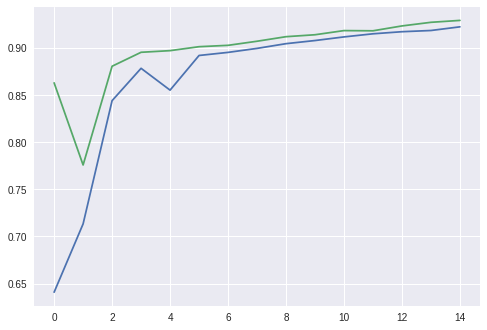

In [26]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

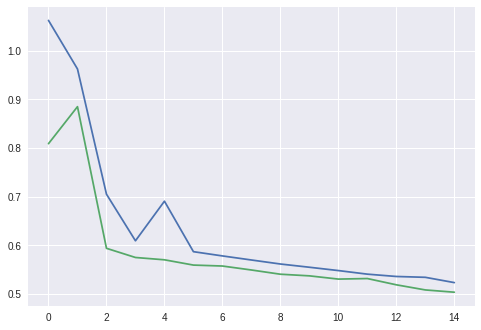

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [34]:
# # loading model
# model = tf.keras.models.load_model('/content/drive/MyDrive/DM LAB/my_model.h5')

In [35]:
# model.summary()

In [28]:
test_question  = ['If I have an object implementing the Map interface in Java and I wish to iterate over every pair contained within it, what is the most efficient way of going through the map? Will the ordering of elements depend on the specific map implementation that I have for the interface?']

In [29]:
seq = tokenizer.texts_to_sequences(test_question)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(padded)

1/1 [==============================] - 1s 1s/step


In [30]:
labels=list(encoder.classes_)
print(np.argmax(pred), labels[np.argmax(pred)])

1 LQ_CLOSE


In [31]:
y_pred=model.predict(x_valid)
y_pred=np.argmax(y_pred,axis=1)

469/469 [==============================] - 7s 14ms/step


In [32]:
y_true=np.argmax(y_valid,axis=1)

In [33]:
target_names = list(encoder.classes_)

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          HQ       0.73      0.69      0.71      5000
    LQ_CLOSE       0.67      0.74      0.70      5000
     LQ_EDIT       0.98      0.92      0.95      5000

    accuracy                           0.78     15000
   macro avg       0.79      0.78      0.79     15000
weighted avg       0.79      0.78      0.79     15000

